# YOLOv1 Implementation with PyTorch

#### BY: NITHIN V SHENOY

## Importing the necessary libraries

In [1]:
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms.v2 as tfm
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time
from collections import Counter

## Basic Utility Functions

In [2]:
def IoU(boxes_preds,boxes_labels,box_format='midpoint'):
    if box_format.lower()=='midpoint':
        x1_preds = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2 
        y1_preds = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        x2_preds = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        y2_preds = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        x1_labels = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        y1_labels = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        x2_labels = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        y2_labels = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    
    elif box_format.lower() == 'corners':
        x1_preds = boxes_preds[..., 0:1]
        y1_preds = boxes_preds[..., 1:2]
        x2_preds = boxes_preds[..., 2:3]
        y2_preds = boxes_preds[..., 3:4] 
        x1_labels = boxes_labels[..., 0:1]
        y1_labels = boxes_labels[..., 1:2]
        x2_labels = boxes_labels[..., 2:3]
        y2_labels = boxes_labels[..., 3:4]
    
    else:
        print("Invalid box format")
        return
    
    epsilon = 1e-6
    
    x1 = torch.max(x1_preds, x1_labels)
    y1 = torch.max(y1_preds, y1_labels)
    x2 = torch.min(x2_preds, x2_labels)
    y2 = torch.min(y2_preds, y2_labels)

    # .clamp(0) for when there is no intersection
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((x2_preds - x1_preds) * (y2_preds - y1_preds))
    box2_area = abs((x2_labels - x1_labels) * (y2_labels - y1_labels))

    return intersection / (box1_area + box2_area - intersection + epsilon)

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="midpoint"):
    # bboxes element format [class_pred, prob_score, x1, y1, w, h]
    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or IoU(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    
    # [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
    # List storing all AP per class
    average_precisions = []
    
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets, and only add the ones that belong to the current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        
        # Count the number of bboxes for each training example
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # Convert the number into a tensor filled with zeros of dim (1,number) for each image
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sort by box probabilities
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exist for this class then skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = IoU(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # Only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # True positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # If IOU is lower, then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

## Defining the architecture

In [3]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding):
        super(CNNBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
    
    def forward(self,x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

class YOLOv1(nn.Module):
    def __init__(self,S,C,B,in_channels=3):
        super(YOLOv1,self).__init__()
        self.in_channels = in_channels
        self.vgg19bnbackbone = models.vgg19_bn(weights='VGG19_BN_Weights.IMAGENET1K_V1').features
        self.yolov1head = self.create_yolov1head()
        
    def forward(self, x):
        x = self.vgg19bnbackbone(x)
        x = self.yolov1head(x)
        return x

    def create_yolov1head(self):
        return nn.Sequential (
            nn.Conv2d(in_channels = 512, out_channels = 1024, 
                      kernel_size = (3, 3), stride = 1,
                      padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, 
                      kernel_size = (3, 3), stride = 2,
                      padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
           
            # Block 6
            nn.Conv2d(in_channels = 1024, out_channels = 1024, 
                      kernel_size = (3, 3), stride = 1,
                      padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels = 1024, out_channels = 1024, 
                      kernel_size = (3, 3), stride = 1,
                      padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),

            nn.Flatten(),
            nn.Linear(in_features = 1024 * S * S, out_features = 4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = 4096, out_features = S * S * (C + B * 5)),
            )
    
    def create_darknet(self):
        return nn.Sequential(
            CNNBlock(self.in_channels,64,7,2,3),
            nn.MaxPool2d(2,2),

            CNNBlock(64,192,3,1,1),
            nn.MaxPool2d(2,2),

            CNNBlock(192,128,1,1,0),
            CNNBlock(128,256,3,1,1),
            CNNBlock(256,256,1,1,0),
            CNNBlock(256,512,3,1,1),
            nn.MaxPool2d(2,2),
            
            CNNBlock(512,256,1,1,0),
            CNNBlock(256,512,3,1,1),
            CNNBlock(512,256,1,1,0),
            CNNBlock(256,512,3,1,1),
            CNNBlock(512,256,1,1,0),
            CNNBlock(256,512,3,1,1),
            CNNBlock(512,256,1,1,0),
            CNNBlock(256,512,3,1,1),
            CNNBlock(512,512,1,1,0),
            CNNBlock(512,1024,3,1,1),
            nn.MaxPool2d(2,2),

            CNNBlock(1024,512,1,1,0),
            CNNBlock(512,1024,3,1,1),
            CNNBlock(1024,512,1,1,0),
            CNNBlock(512,1024,3,1,1),
            CNNBlock(1024,1024,3,1,1),
            CNNBlock(1024,1024,3,2,1),
            CNNBlock(1024,1024,3,1,1),
            CNNBlock(1024,1024,3,1,1)
            
        )
    def create_fcs(self,S,C,B):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(S*S*1024,4096),
            nn.Dropout(0.3),
            nn.LeakyReLU(0.1),
            nn.Linear(4096,S*S*(C+B*5))
        )

## Defining the loss function

In [4]:
class YOLOLoss(nn.Module):
    def __init__(self,device,S=7,B=2,C=20):
        super(YOLOLoss,self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.device = device
        self.S = S
        self.B = B
        self.C = C
        
        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        
    def forward(self, preds, labels):
        # Preds shape : (BATCH_SIZE, S*S*(C+B*5))
        preds = preds.reshape(-1, self.S, self.S, self.C + self.B * 5).to(device) # preds shape : (BATCH_SIZE, S, S, C+5B)
        labels = labels.to(device)
        # Get the list of all IoUs with the label in the batch
        iou_list = []
        for b in range(self.B):
            iou_list.append(IoU(preds[...,self.C+1+5*b:self.C+5*(b+1)],labels[...,self.C+1:self.C+5]).unsqueeze(0))
        
        iou_list = torch.cat(iou_list,dim=0) # iou_list shape : (B,BATCH_SIZE,S,S)
        
        iou_maxes, bestbox = torch.max(iou_list, dim=0) # iou_maxes and bestbox shape : (BATCH_SIZE,S,S,1)
        bestbox.to(self.device)
        
        label_exists = labels[...,self.C].unsqueeze(3) # label_exists shape : (BATCH_SIZE,S,S,1)
        
        # Box Loss
        
        """Concatenate all the box coordinate tensors such that
           you have a (BATCH_SIZE,S,S,B,4) tensor. Then you multiply this with
           the one_hot_encoded_bestbox tensor of the shape (BATCH_SIZE,S,S,B) 
           and sum all the resulting tensors up. You will get a tensor of the shape
           (BATCH_SIZE,S,S,4). Then you multiply with label_exists to only
           get the box coordinates for the cells with a target box."""
        
        pred_boxes = torch.cat([preds[..., self.C+1+5*i:self.C+5*(i+1)] for i in range(self.B)], dim=-1) # pred_boxes shape : (BATCH_SIZE,S,S,4B)
        
        pred_boxes = pred_boxes.reshape(-1,self.S,self.S,self.B,4) # pred_boxes shape : (BATCH_SIZE,S,S,B,4)
        
        # One-Hot encode bestbox
        
        one_hot_bestbox = torch.zeros((preds.size(0), self.S, self.S, self.B)).to(self.device) # one_hot_bestbox shape : (BATCH_SIZE,S,S,B)
        
        one_hot_bestbox.scatter_(3, bestbox.expand(-1,-1,-1, self.B), 1) # one_hot_bestbox shape : (BATCH_SIZE,S,S,B)
        
        # Get the best box coordinate matrix for the each cell in each image
        box_pred_coords = label_exists * (pred_boxes*one_hot_bestbox.unsqueeze(-1)).sum(dim=-2) # box_pred_coords shape : (BATCH_SIZE,S,S,4); [x,y,w,h] for each cell in each image
        
        # Get the coordinate matrix for the label of each cell in each image
        box_label_coords = label_exists * labels[...,21:25] # box_label_coords shape : (BATCH_SIZE,S,S,4)
        
        # Take sqrt of width and height of boxes while preserving the sign of w and h
        box_pred_coords[..., 2:4] = torch.sign(box_pred_coords[..., 2:4]) * torch.sqrt(
            torch.abs(box_pred_coords[..., 2:4] + 1e-6))
        
        box_label_coords[..., 2:4] = torch.sqrt(box_label_coords[..., 2:4])
        
        # Calculate the mse loss. We will multiply with lamba_coord later
        box_loss = self.mse(
            torch.flatten(box_pred_coords, end_dim=-2),
            torch.flatten(box_label_coords, end_dim=-2),
        )
        
        # Object Loss
        
        pred_confidences = torch.cat([preds[..., self.C+5*i:self.C+1+5*i] for i in range(self.B)], dim=-1) # pred_confidences shape : (BATCH_SIZE,S,S,B)
        
        obj_pred_confidences = (pred_confidences*one_hot_bestbox) # obj_pred_confidences shape : (BATCH_SIZE,S,S,1)
        
        obj_pred_confidences = obj_pred_confidences.sum(dim=-1).unsqueeze(-1)
        
        object_loss = self.mse(
            torch.flatten(label_exists * obj_pred_confidences),
            torch.flatten(label_exists * labels[..., 20:21]),
        )
        
        # No Object Loss
        
        label_absent = 1 - label_exists
        
        no_object_loss = self.mse(
            torch.flatten(label_absent * obj_pred_confidences),
            torch.flatten(label_absent * labels[..., 20:21]),
        )
        
        # Class Loss
        
        pred_classes = preds[...,:self.C]
        
        label_classes = labels[...,:self.C]
        
        class_loss = self.mse(
            torch.flatten(label_exists * pred_classes, end_dim = -2),
            torch.flatten(label_exists * label_classes, end_dim = -2)
        )
        
        # Final loss
        
        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )
        
        return loss

## Importing the PASCAL VOC Dataset

In [5]:
# Load datasets
train_dataset_2007 = torchvision.datasets.VOCDetection(root='data', year="2007", image_set='trainval', download=True)
test_dataset_2007 = torchvision.datasets.VOCDetection(root='data', year='2007', image_set='test', download=True)
train_dataset_2012 = torchvision.datasets.VOCDetection(root='data', year='2012', image_set='train', download=True)
test_dataset_2012 = torchvision.datasets.VOCDetection(root='data', year='2012', image_set='val', download=True)

# Combine training datasets
train_dataset_full = torch.utils.data.ConcatDataset([train_dataset_2007, train_dataset_2012])

# Combine test datasets
testval_dataset = torch.utils.data.ConcatDataset([test_dataset_2007, test_dataset_2012])

# Create validation and test datasets using Subset
val_size = 2000  # Number of validation samples
test_size = len(testval_dataset) - val_size  # Number of test samples

# Create indices for the validation and test datasets
val_indices = list(range(test_size, len(testval_dataset)))  # Last 2000 indices for validation
test_indices = list(range(test_size))  # First part of the indices for test

# Create subsets for validation and test datasets
val_dataset = torch.utils.data.Subset(testval_dataset, val_indices)
test_dataset = torch.utils.data.Subset(testval_dataset, test_indices)


Using downloaded and verified file: data/VOCtrainval_06-Nov-2007.tar
Extracting data/VOCtrainval_06-Nov-2007.tar to data
Using downloaded and verified file: data/VOCtest_06-Nov-2007.tar
Extracting data/VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


## Balancing the dataset
#### The original dataset has too many 'person' obects resulting in improper training. So some of such images are removed.

In [6]:
num_persons = 0
threshold = 8000
removed_indices = []
for i in range(len(train_dataset_full)):
    person_count_img = 0
    objects_list = train_dataset_full[i][1]['annotation']['object']
    for obj in objects_list:
        if obj['name'].lower() == 'person':
            person_count_img += 1

    if person_count_img >= 1:
        num_persons += person_count_img
        removed_indices.append(i)
    if num_persons >=threshold:
        print(num_persons)
        print(len(removed_indices))
        break        

all_indices = set(range(len(train_dataset_full)))

removed_indices_set = set(removed_indices)

keep_indices = list(all_indices - removed_indices_set)

train_dataset = torch.utils.data.Subset(train_dataset_full, keep_indices)

8002
3143


## Getting the distribution of the classes
###### (Commented out so it doesn't run everytime)

In [7]:
counter = {}

dataset = train_dataset

for index,img_annotation in enumerate(dataset):
    img,annotation = img_annotation
    class_labels = [obj['name'] for obj in annotation['annotation']['object']]
    for class_label in class_labels:
        if class_label not in list(counter.keys()):
            counter[class_label] = 1
        else:
            counter[class_label] += 1
    if index%1000==0:
        print(round(100*index/len(dataset),2),"%")

print(counter)

0.0 %
13.18 %
26.37 %
39.55 %
52.74 %
65.92 %
79.1 %
92.29 %
{'chair': 2129, 'car': 1916, 'bicycle': 366, 'cat': 946, 'train': 551, 'aeroplane': 725, 'dog': 1072, 'tvmonitor': 602, 'bird': 1100, 'pottedplant': 920, 'boat': 735, 'motorbike': 366, 'sofa': 589, 'sheep': 813, 'cow': 572, 'bus': 416, 'diningtable': 424, 'horse': 357, 'bottle': 838, 'person': 2464}


## Plotting the distribution

17901 objects


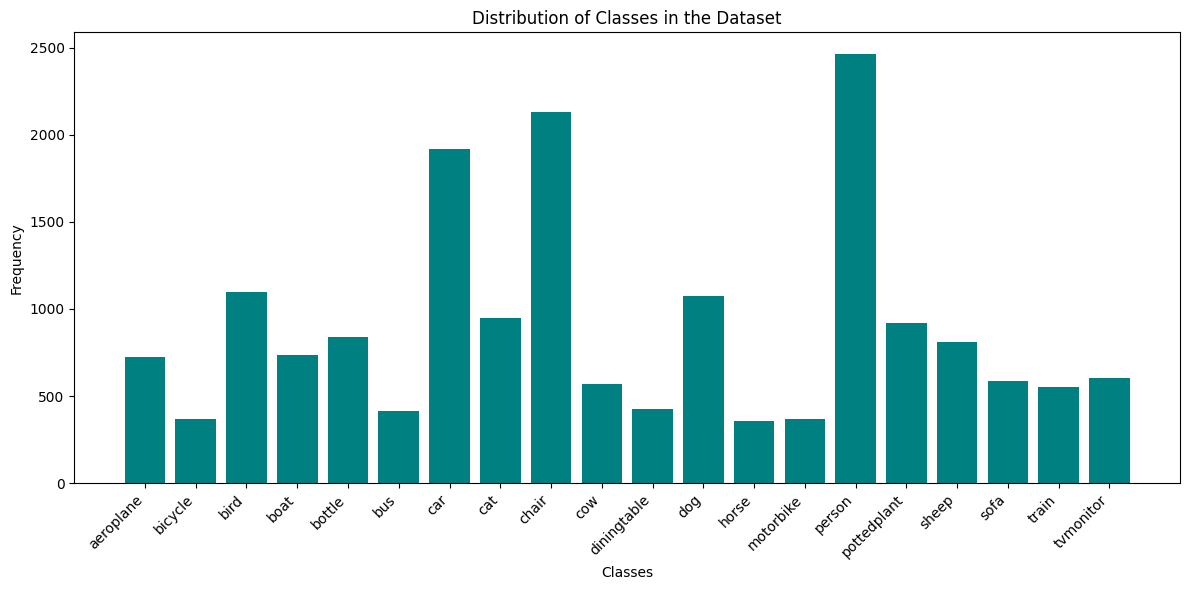

In [8]:
distribution = {'chair': 2129, 'car': 1916, 'bicycle': 366, 'cat': 946, 'train': 551,
                'aeroplane': 725, 'dog': 1072, 'tvmonitor': 602, 'bird': 1100,
                'pottedplant': 920, 'boat': 735, 'motorbike': 366, 'sofa': 589,
                'sheep': 813, 'cow': 572, 'bus': 416, 'diningtable': 424, 'horse': 357,
                'bottle': 838, 'person': 2464}
distribution = dict(sorted(distribution.items()))
classes = list(distribution.keys())
counts = list(distribution.values())
print(np.sum(counts), 'objects')

plt.style.use('default')

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='teal')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Distribution of Classes in the Dataset')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()  
plt.show()

## Creating the dataset for YOLOv1


In [9]:
img_size = 448

transform = tfm.Compose([
    tfm.RandomAffine(degrees=0,translate=[0,0.2],scale=[1,1.2]),
    tfm.ColorJitter(brightness=[1,1.5],saturation=[1,1.5]),
    tfm.Resize((img_size, img_size)),
    tfm.ToImage(),
    tfm.ToDtype(torch.float32, scale=True)
])

eval_transform = tfm.Compose([
    tfm.Resize((img_size, img_size)),
    tfm.ToImage(),
    tfm.ToDtype(torch.float32, scale=True)
])


class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, S, B, C, dataset, transform):
        self.S = S
        self.B = B
        self.C = C
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def class_to_index(self, name):
        classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                   'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                   'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                   'sheep', 'sofa', 'train', 'tvmonitor']

        return classes.index(name)

    def __getitem__(self, index):
        global img_size
        img, label_voc = self.dataset[index]
        
        label_yolo = np.zeros((self.S, self.S, self.C + 5))
        boxes_corner = [obj['bndbox'] for obj in label_voc['annotation']['object']]
        boxes = []
        for box in boxes_corner:
            w = int(box['xmax']) - int(box['xmin'])
            h = int(box['ymax']) - int(box['ymin'])
            x = (int(box['xmax']) + int(box['xmin'])) / 2
            y = (int(box['ymax']) + int(box['ymin'])) / 2
            boxes.append([x, y, w, h])
        
        canvas_size = [int(label_voc['annotation']['size']['height']), int(label_voc['annotation']['size']['width'])]
        
        boxes = torchvision.tv_tensors.BoundingBoxes(boxes, format="XYWH", canvas_size=canvas_size)

        del boxes_corner

        if self.transform:
            img, boxes = self.transform(img, boxes)

        class_labels = [obj['name'] for obj in label_voc['annotation']['object']]

        grid_size = img_size // self.S

        for index, box in enumerate(boxes):
            i = min(int(box[1] // grid_size),self.S-1)
            j = min(int(box[0] // grid_size),self.S-1)
            if i==7 or j==7 or i==-1 or j==-1:
                print("___")
                print(img.shape)
                print(box)
                print(i,j)
                print(index)

            class_label = self.class_to_index(class_labels[index])

            label_yolo[i, j][class_label] = 1
            label_yolo[i, j][self.C] = 1
            label_yolo[i, j][self.C + 1:] = np.array([(box[0]%grid_size)/grid_size,(box[1]%grid_size)/grid_size,
                                                      box[2]/grid_size,box[3]/grid_size])

        return img, label_yolo


## Initialising the dataset

In [10]:
S = 7
B = 2
C = 20

train_dataset_yolo = VOCDataset(S,B,C,train_dataset,transform)
val_dataset_yolo = VOCDataset(S,B,C,val_dataset,transform)
test_dataset_yolo = VOCDataset(S,B,C,test_dataset,transform)

print(len(train_dataset_yolo),'training images')
print(len(val_dataset_yolo),'validation images')
print(len(test_dataset_yolo),'testing images')

7585 training images
2000 validation images
8775 testing images


## Visualising the training data

[[96, 97, 330, 331]]


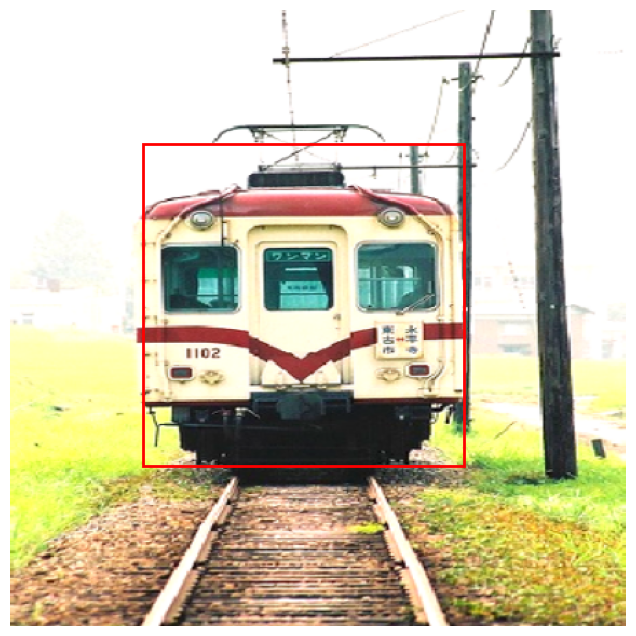

In [15]:

# Get a sample image and its corresponding bounding boxes
sample_index = 246 # Change this index to get a different sample
img, label_yolo = train_dataset_yolo[sample_index]

# Convert the image tensor back to a numpy array (H, W, C)
img = img.permute(1, 2, 0).numpy()

boxes = []

grid_size = img_size//S

for i in range(train_dataset_yolo.S):
    for j in range(train_dataset_yolo.S):
        if label_yolo[i, j, 20] == 1:  # Assuming 20 is the object presence indicator
            x_center = label_yolo[i, j, train_dataset_yolo.C + 1]  # x
            y_center = label_yolo[i, j, train_dataset_yolo.C + 2]  # y
            width = label_yolo[i, j, train_dataset_yolo.C + 3]     # width
            height = label_yolo[i, j, train_dataset_yolo.C + 4]    # height
            
            # Calculate the top-left and bottom-right coordinates
            x_min = int(grid_size*(j + x_center - width / 2))
            y_min = int(grid_size*(i + y_center - height / 2))
            x_max = int(grid_size*(j + x_center + width / 2))
            y_max = int(grid_size*(i + y_center + height / 2))

            boxes.append([x_min, y_min, x_max, y_max])

print(boxes)
# Plot the image and draw bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box in boxes:
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

# Show the plot
plt.axis('off')
plt.show()

## Initialising the model

In [16]:
train_from_scratch = False
if train_from_scratch:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    yolov1 = YOLOv1(S,C,B)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        yolov1 = nn.DataParallel(yolov1)
    
    yolov1 = yolov1.to(device)  # Send model to GPU(s)
    

## Importing pre-trained model
#### Pre-trained DarkNet weights were not found so it is replaced by VGG-19BN

In [18]:
# Path to the .cpt file
# Source : https://github.com/sendeniz/yolov1-real-time-obj-detection/tree/main
model_path = '/kaggle/input/yolov1_vgg19bn_pretrained/pytorch/default/1/vgg19bn_adj_lr_yolov1.cpt'

# Initialize your YOLOv1 model
yolov1 = YOLOv1(S,C,B)

# Load the saved state_dict
yolov1.load_state_dict(torch.load(model_path,weights_only=True)['model_state_dict'])

print("Model loaded successfully.")

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 219MB/s] 


Model loaded successfully.


## Initialising the optimizer and scheduler

In [19]:
train = True or train_from_scratch
device = 'cuda'
if train:
    
    yolo_loss = YOLOLoss(device,S,B,C)
    optimizer = torch.optim.SGD(yolov1.parameters(),lr=1e-6,momentum=0.9,weight_decay=0.0005) 
    
    warmup_epochs = 5
    
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return 1 + (10 - 1) * (epoch / warmup_epochs)
        elif epoch < 75:
            return 10
        elif epoch < 105:
            return 1
        else:
            return 0.1
        
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

## Training the model
#### Training is skipped due to time and power constraints

In [20]:
if train:
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        yolov1 = nn.DataParallel(yolov1)
    yolov1 = yolov1.to('cuda')
    train_data = torch.utils.data.DataLoader(train_dataset_yolo,batch_size=16,shuffle=True,num_workers=4)
    # val_data = torch.utils.data.DataLoader(val_dataset_yolo,batch_size=16,shuffle=True,num_workers=2)
    
    batch_size = 16
    exp_time_flag = False
    exp_batch_num = 40
    num_epochs = 5
    
    train_errors = []
    val_errors = []
    
    for epoch in range(num_epochs):
        avg_train_loss = 0
        avg_val_loss = 0
        start = time.time()
        yolov1.train()
        for batch_num,batch in enumerate(train_data):
            X,y = batch
            
            X,y = X.to(device),y.to(device)
            
            pred = yolov1(X)
            loss = yolo_loss(pred,y)
            
            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()
            
            if not exp_time_flag and batch_num == exp_batch_num-1:
                exp_time_flag = True
                print(f"{((time.time()-start)*len(train_data)*num_epochs/(60*exp_batch_num)):.2f}","minutes expected")
    
            if (batch_num+1) %(len(train_data)//8)==0:
                print(f"Batch {batch_num+1} : {(avg_train_loss/(batch_num)):.4f} : {(time.time()-start):.2f} seconds")
                start = time.time()
    
            avg_train_loss += loss.item()

        scheduler.step()
            
        print(f"Epoch : {epoch+1}   Loss : {avg_train_loss/len(train_data)}   lr : {optimizer.param_groups[0]['lr']}")
        train_errors.append(avg_train_loss/len(train_data))
        
        # yolov1.eval()
        
        # for batch_num,batch in enumerate(val_data):
        #     X,y = batch
            
        #     X,y = X.to(device),y.to(device)
            
        #     pred = yolov1(X)
        #     loss = yolo_loss(pred,y)
            
        #     avg_val_loss +=loss.item()
        # print(f"Validation loss : {avg_val_loss/len(val_data)}")
        # val_errors.append(avg_val_loss/len(val_data))
        
        
    with open('model_state1.pt','wb') as f:
        torch.save(yolov1.state_dict(),f)
        


27.42 minutes expected
Batch 59 : 115.6537 : 40.15 seconds
Batch 118 : 107.1682 : 38.70 seconds
Batch 177 : 104.1979 : 38.76 seconds
Batch 236 : 102.8208 : 38.87 seconds
Batch 295 : 101.4678 : 38.77 seconds
Batch 354 : 100.3943 : 38.78 seconds
Batch 413 : 99.1724 : 38.85 seconds
Batch 472 : 97.5339 : 38.78 seconds
Epoch : 1   Loss : 97.3089900742889   lr : 2.8e-06
Batch 59 : 82.7312 : 38.95 seconds
Batch 118 : 82.5704 : 38.72 seconds
Batch 177 : 81.3757 : 38.78 seconds
Batch 236 : 80.7686 : 38.84 seconds
Batch 295 : 79.2386 : 38.79 seconds
Batch 354 : 79.7599 : 38.84 seconds
Batch 413 : 78.8983 : 38.84 seconds
Batch 472 : 77.5670 : 38.76 seconds
Epoch : 2   Loss : 77.36058032650587   lr : 4.599999999999999e-06
Batch 59 : 70.1968 : 39.01 seconds
Batch 118 : 69.3821 : 38.80 seconds
Batch 177 : 68.9345 : 38.82 seconds
Batch 236 : 67.4419 : 38.76 seconds
Batch 295 : 66.4982 : 38.89 seconds
Batch 354 : 65.4551 : 38.85 seconds
Batch 413 : 65.2876 : 38.85 seconds
Batch 472 : 64.7345 : 38.85 s

## Plotting the training and validation errors

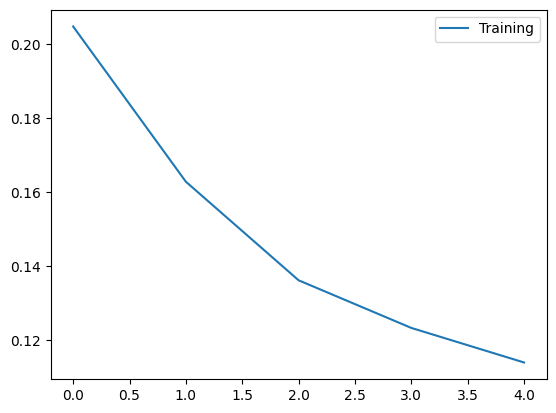

In [22]:
if train:
    train_errors = np.array(train_errors)
    val_errors = np.array(val_errors)
    
    plt.plot(train_errors/len(train_data),label='Training')
    plt.plot(val_errors/len(val_data),label='Validation')
    plt.legend()
    plt.show()

##### If training has been stopped early, then this snippet is ran to save the model

In [21]:
if train:
    with open('yolov1_vgg19bn_trained.pt','wb') as f:
        torch.save(yolov1.state_dict(),f)

## Loading saved model

###### (Commented out so it doesn't run everytime)

In [25]:
yolov1 = YOLOv1(S,C,B)
state_dict = torch.load('/kaggle/working/yolov1_vgg19bn_trained.pt',weights_only = False)

yolov1.load_state_dict(state_dict)

<All keys matched successfully>

## Inference 


1773
98 boxes before nms
[[12, 1, 158, 97, 351, 331]]
1 boxes after nms


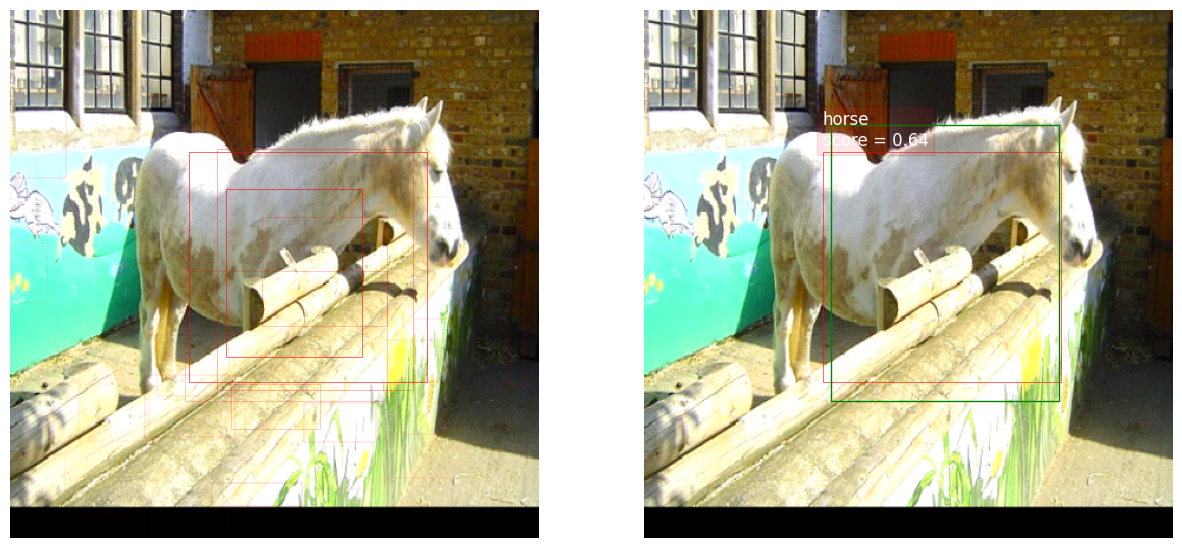

In [24]:
yolov1.eval()
yolov1.to('cuda')
# Get a sample image and its corresponding bounding boxes
sample_index = np.random.randint(0,2000) # Change this index to get a different sample
print(sample_index)
# sample_index = 1315 # Cluster of sheeps
img, label_yolo = train_dataset_yolo[sample_index]
label_yolo = torch.tensor(label_yolo)
pred = yolov1(img.unsqueeze(0).to('cuda'))[0].reshape(7,7,30)

classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                   'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                   'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                   'sheep', 'sofa', 'train', 'tvmonitor']

# Convert the image tensor back to a numpy array (H, W, C)
img = img.permute(1, 2, 0).numpy()

boxes = []
ground_truth = []

grid_size = img_size//S

for i in range(S):
    for j in range(S):
        
        if label_yolo[i,j,C] == 1:
            x_center = label_yolo[i, j,C + 1]  # x
            y_center = label_yolo[i, j,C +2]  # y
            width = label_yolo[i, j,C + 3]     # width
            height = label_yolo[i, j,C + 4]    # height

            # Calculate the top-left and bottom-right coordinates
            x_min = int(grid_size*(j + x_center - width / 2))
            y_min = int(grid_size*(i + y_center - height / 2))
            x_max = int(grid_size*(j + x_center + width / 2))
            y_max = int(grid_size*(i + y_center + height / 2))
            
            class_true = torch.argmax(label_yolo[i,j,:C])
            ground_truth.append([int(class_pred),1,x_min, y_min, x_max, y_max])
        
        for k in range(B):
            x_center = pred[i, j,C + 1 + 5*k]  # x
            y_center = pred[i, j,C +2+5*k]  # y
            width = pred[i, j,C + 3+5*k]     # width
            height = pred[i, j,C + 4+5*k]    # height

            # Calculate the top-left and bottom-right coordinates
            x_min = int(grid_size*(j + x_center - width / 2))
            y_min = int(grid_size*(i + y_center - height / 2))
            x_max = int(grid_size*(j + x_center + width / 2))
            y_max = int(grid_size*(i + y_center + height / 2))
            
            class_pred = torch.argmax(pred[i,j,:C])

            boxes.append([int(class_pred),float(pred[i,j,C+5*k]),x_min, y_min, x_max, y_max])
            

print(len(boxes),"boxes before nms")

boxes_nms = non_max_suppression(boxes,0.2,0.6,box_format='corners')

print(ground_truth)

print(len(boxes_nms),"boxes after nms")

def func(x):
    return x[1]

if len(boxes_nms) == 0:
    boxes.sort(key = func,reverse=True)
    boxes_nms.append(boxes[0])

# Plot the image and draw bounding boxes
fig, ax = plt.subplots(1,2, figsize=(15, 10))
for a in ax:
    a.imshow(img)
    a.axis('off')

for box in boxes:
    score = max(round(box[1],2),0)

    # Create a Rectangle patch
    rect = patches.Rectangle((box[2], box[3]), box[4] - box[2], box[5] - box[3],
                             linewidth=box[1], edgecolor='red', facecolor='none',alpha = min(score,1))
    
    ax[0].add_patch(rect)
    label_text = ''
    ax[0].text(box[2], box[3] - 5, label_text, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=min(score,1)))

for box in boxes_nms:
    score = round(box[1],2)
    # Create a Rectangle patch
    rect = patches.Rectangle((box[2], box[3]), box[4] - box[2], box[5] - box[3],
                             linewidth=box[1], edgecolor='red', facecolor='none',alpha = min(score,1))
    
    ax[1].add_patch(rect)
    label_text = classes[box[0]] + '\n' + 'score = '+ str(round(box[1],2))
    ax[1].text(box[2], box[3] - 5, label_text, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.1))
    
for box in ground_truth:
    # Create a Rectangle patch
    rect = patches.Rectangle((box[2], box[3]), box[4] - box[2], box[5] - box[3],
                             linewidth=box[1], edgecolor='green', facecolor='none')
    
    ax[1].add_patch(rect)
    label_text = ''
    ax[1].text(box[2], box[3] - 5, label_text, color='white', fontsize=12, bbox=dict(facecolor='green', alpha=0))


# Show the plot
plt.show()

## Evaluation 

In [166]:
batch_size = 128
test_data = torch.utils.data.DataLoader(test_dataset_yolo,batch_size=batch_size,shuffle =False,num_workers=4)

classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                   'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                   'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                   'sheep', 'sofa', 'train', 'tvmonitor']

yolov1.eval()
device = 'cuda'
yolov1 = yolov1.to('cuda')
grid_size = img_size//S
start = time.time()
pred_boxes = []
true_boxes = []
counter = 0
verbose_interval = 24
# iou_range = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
iou_range = [0.5]
nms_params = [(0.7,0.85),(0.7,0.4),(0.2,0.6),(0.3,0.6),(0.5,0.5)]
maps = []
pred_boxes = []
true_boxes = []
avg_boxes = 0
for iou_nms, score_nms in nms_params:
    avg_boxes = 0
    counter = 0
    for batch_num, batch in enumerate(test_data):
        if batch_num>=4:
            break
        X, y = batch
    
        # Get the dataset indices corresponding to this batch
        batch_indices = range(batch_num * test_data.batch_size, 
                              min((batch_num + 1) * test_data.batch_size, len(test_data.dataset)))
    
        X, y = X.to(device), y.to(device)
    
        for img_idx, dataset_idx in enumerate(batch_indices):  # Iterate through images in the batch
            # Get the prediction for this specific image in the batch
            pred = yolov1(X[img_idx].unsqueeze(0))  # Pass a single image to the model
            label = y[img_idx]
            pred = pred.reshape(1,7,7,30)
            boxes = []
    
            gt = []
            
            for i in range(S):
                for j in range(S):
                    if label[i,j,C] == 1:
                        x_center = label[i, j, C + 1]  # x
                        y_center = label[i, j, C + 2]  # y
                        width = label[i, j, C + 3]     # width
                        height = label[i, j, C + 4]    # height
    
                        # Calculate the top-left and bottom-right coordinates
                        x_min = int(grid_size * (j + x_center - width / 2))
                        y_min = int(grid_size * (i + y_center - height / 2))
                        x_max = int(grid_size * (j + x_center + width / 2))
                        y_max = int(grid_size * (i + y_center + height / 2))
    
                        class_true = torch.argmax(label[i,j,:C])
    
                        gt.append([dataset_idx,class_true,1,x_min,y_min,x_max,y_max]) 
                    
                    for k in range(B):
                        x_center = pred[0, i, j, C + 1 + 5 * k]  # x
                        y_center = pred[0, i, j, C + 2 + 5 * k]  # y
                        width = pred[0, i, j, C + 3 + 5 * k]     # width
                        height = pred[0, i, j, C + 4 + 5 * k]    # height
    
                        # Calculate the top-left and bottom-right coordinates
                        x_min = int(grid_size * (j + x_center - width / 2))
                        y_min = int(grid_size * (i + y_center - height / 2))
                        x_max = int(grid_size * (j + x_center + width / 2))
                        y_max = int(grid_size * (i + y_center + height / 2))
    
                        class_pred = torch.argmax(pred[0, i, j, :C])
    
                        boxes.append([int(class_pred), float(pred[0, i, j, C + 5 * k]), x_min, y_min, x_max, y_max])
    
            # Apply Non-Max Suppression for this image
            boxes_nms = non_max_suppression(boxes, iou_nms, score_nms, box_format='corners')

            avg_boxes += len(boxes_nms)
            counter += 1
            # Associate predictions with the dataset index
            pred_box_img = [[dataset_idx] + box for box in boxes_nms]
            pred_boxes += pred_box_img
            true_boxes += gt
    
        if (batch_num + 1) % (len(test_data) // verbose_interval) == 0:
            counter += 1
            print(f"Batch {batch_num + 1} / {max_examples//batch_size + 1} : {(time.time() - start):.2f} seconds ")
            start = time.time()
    
    for iou in iou_range:
        mAP = float(mean_average_precision(pred_boxes, true_boxes,iou_threshold = iou, box_format='corners'))
        maps.append([(iou_nms,score_nms,iou),mAP,avg_boxes/counter])
        
print(maps)

Batch 2 / 8 : 21.02 seconds 
Batch 4 / 8 : 15.27 seconds 
Batch 2 / 8 : 24.97 seconds 
Batch 4 / 8 : 16.80 seconds 
Batch 2 / 8 : 27.75 seconds 
Batch 4 / 8 : 15.36 seconds 
Batch 2 / 8 : 30.96 seconds 
Batch 4 / 8 : 15.57 seconds 
Batch 2 / 8 : 35.59 seconds 
Batch 4 / 8 : 15.80 seconds 
[[(0.7, 0.85, 0.5), 0.144489586353302, 1.1809338521400778], [(0.7, 0.4, 0.5), 0.19533652067184448, 9.696498054474707], [(0.2, 0.6, 0.5), 0.17495521903038025, 2.2587548638132295], [(0.3, 0.6, 0.5), 0.15948359668254852, 2.5311284046692606], [(0.5, 0.5, 0.5), 0.16171276569366455, 5.011673151750973]]


In [ ]:
# mAP@0.5 = 26.1% for score = 0.3 trained vgg19bn
# mAP@0.7 = 31.1% for score = 0.3 trained vvg19bn